In [15]:
import warnings
import scanpy as sc
import squidpy as sq
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

## Global variables

In [12]:
dir_path = '../../results/DiffExpr/pseudobulks/'

In [13]:
os.listdir(dir_path)

['annotation_chimp.csv',
 'annotation_human.csv',
 'annotation_macaque.csv',
 'annotation_spatial_libd_human.csv',
 'expression_chimp.csv',
 'expression_human.csv',
 'expression_macaque.csv',
 'expression_mean_chimp.csv',
 'expression_mean_human.csv',
 'expression_mean_macaque.csv',
 'expression_mean_spatial_libd_human.csv',
 'expression_spatial_libd_human.csv',
 'expression_sum_chimp.csv',
 'expression_sum_human.csv',
 'expression_sum_macaque.csv',
 'expression_sum_spatial_libd_human.csv',
 'gene_sample_mean_chimp.csv',
 'gene_sample_mean_human.csv',
 'gene_sample_mean_macaque.csv',
 'gene_sample_mean_spatial_libd_human.csv',
 'pb_age_sample_norm.h5ad',
 'pb_mamm_sample_norm.h5ad']

# ANOVA

In [14]:
file_name = 'pb_mamm_sample_norm.h5ad'
adata = sc.read_h5ad(dir_path + file_name)
adata

AnnData object with n_obs × n_vars = 94 × 15585
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [23]:
adata = adata[:, adata.X.sum(axis=0) > 0]

df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
df['condition'] = adata.obs.condition
df['layer'] = adata.obs.layer

df_var_num = df.copy()
df_var_num.columns = [f'gene{i}' for i in range(1, df_var_num.shape[1] - 1)] + ['condition', 'layer']

In [47]:
formula = f'gene1 ~ condition + layer + condition:layer'
model = ols(formula, data=df_var_num).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
condition,0.000013,2.0,0.057747,9.439318e-01
layer,0.006142,6.0,8.767435,3.405377e-07
condition:layer,0.001049,12.0,0.748589,6.996934e-01
Residual,0.008523,73.0,NaN,NaN


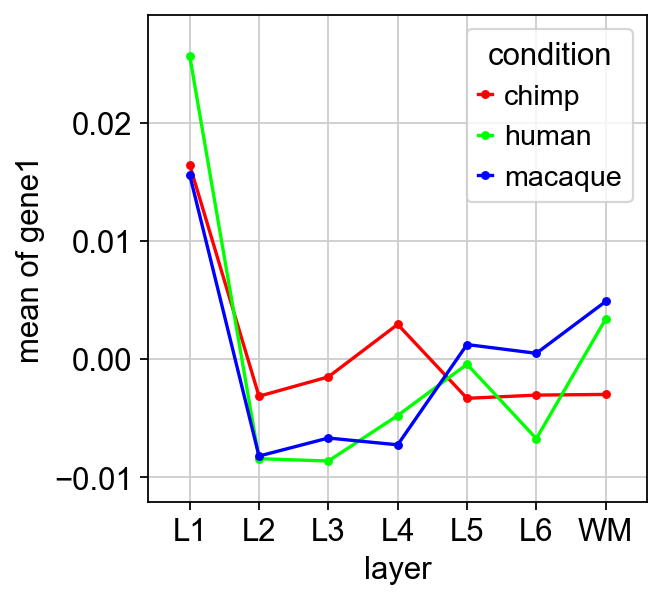

In [36]:
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig = interaction_plot(x=df_var_num['layer'].astype('str'), trace=df_var_num['condition'].astype('str'), response=df_var_num['gene1'])
plt.show()

In [37]:
adata = adata[:, adata.X.sum(axis=0) > 0]

df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
df['condition'] = adata.obs.condition
df['layer'] = adata.obs.layer

df_var_num = df.copy()
df_var_num.columns = [f'gene{i}' for i in range(1, df_var_num.shape[1] - 1)] + ['condition', 'layer']

results = []

for gene in tqdm(df_var_num.columns.tolist()[:-2]):
    formula = f'{gene} ~ condition + layer + condition:layer'
    model = ols(formula, data=df_var_num).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    results.append(aov_table.loc['condition:layer'].tolist())

columns = ['sum_sq', 'df', 'F', 'PR(>F)']
res = pd.DataFrame(results, columns=columns, index=adata.var_names)
mult_test = multipletests(res['PR(>F)'], method='fdr_bh')
res['p_val_adj'] = mult_test[1]
res.to_csv(f'../../results/DiffExpr/ANOVA/anova_mamm.csv')

  0%|          | 0/6541 [00:00<?, ?it/s]

OSError: Cannot save file into a non-existent directory: '..\results\DiffExpr\ANOVA'

In [39]:
res

,sum_sq,df,F,PR(>F),p_val_adj
SAMD11,0.001049,12.0,0.748589,6.996934e-01,7.685465e-01
HES4,0.045426,12.0,1.822630,6.001060e-02,1.162017e-01
ACAP3,0.051589,12.0,1.897710,4.854772e-02,9.771276e-02
CPTP,0.038015,12.0,1.095717,3.767850e-01,4.918281e-01
TAS1R3,0.006636,12.0,2.273784,1.628953e-02,3.955080e-02
...,...,...,...,...,...
COL6A2,0.724954,12.0,11.637091,1.180279e-12,4.825130e-11
SPATC1L,0.125344,12.0,3.781871,1.800420e-04,9.024174e-04
YBEY,0.012853,12.0,1.102733,3.712196e-01,4.866545e-01
PCNT,0.008133,12.0,0.642695,7.988832e-01,8.492597e-01


<AxesSubplot: >

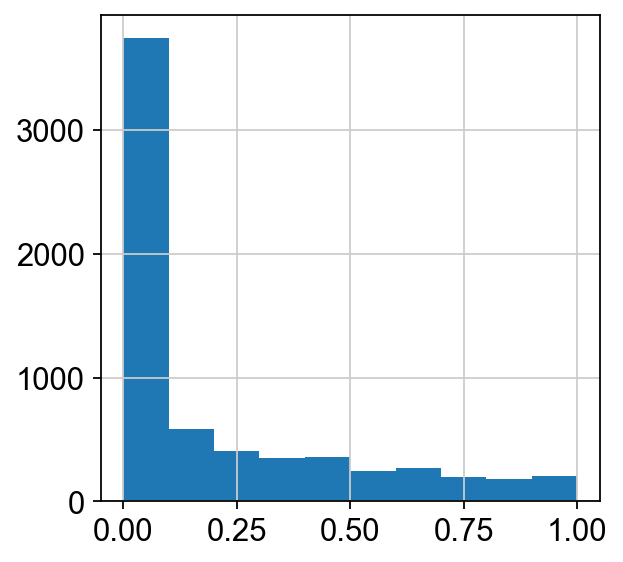

In [40]:
res['PR(>F)'].hist()

In [52]:
m_comp._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
chimp / L1,chimp / L2,-0.0196,0.7986,-0.0523,0.0131,False
chimp / L1,chimp / L3,-0.0179,0.7657,-0.0472,0.0113,False
chimp / L1,chimp / L4,-0.0135,0.9772,-0.0427,0.0157,False
chimp / L1,chimp / L5,-0.0198,0.6078,-0.049,0.0095,False
chimp / L1,chimp / L6,-0.0195,0.6328,-0.0487,0.0097,False
chimp / L1,chimp / WM,-0.0194,0.638,-0.0487,0.0098,False
chimp / L1,human / L1,0.0092,0.9998,-0.02,0.0385,False
chimp / L1,human / L2,-0.0249,0.2016,-0.0541,0.0044,False
chimp / L1,human / L3,-0.0251,0.1908,-0.0543,0.0042,False
chimp / L1,human / L4,-0.0212,0.4741,-0.0504,0.008,False


In [53]:
tukey_data

,group1,group2,meandiff,p-adj,lower,upper,reject
0,chimp / L1,chimp / L2,-0.0196,0.7986,-0.0523,0.0131,False
1,chimp / L1,chimp / L3,-0.0179,0.7657,-0.0472,0.0113,False
2,chimp / L1,chimp / L4,-0.0135,0.9772,-0.0427,0.0157,False
3,chimp / L1,chimp / L5,-0.0198,0.6078,-0.0490,0.0095,False
4,chimp / L1,chimp / L6,-0.0195,0.6328,-0.0487,0.0097,False
...,...,...,...,...,...,...,...
205,macaque / L4,macaque / L6,0.0077,1.0000,-0.0206,0.0360,False
206,macaque / L4,macaque / WM,0.0121,0.9899,-0.0162,0.0404,False
207,macaque / L5,macaque / L6,-0.0007,1.0000,-0.0290,0.0276,False
208,macaque / L5,macaque / WM,0.0036,1.0000,-0.0247,0.0319,False


In [50]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df_var_num['combination'] = df_var_num.condition.astype('str') + " / " + df_var_num.layer.astype('str')

# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df_var_num['gene1'], groups=df_var_num['combination'], alpha=0.05)

# coerce the tukeyhsd table to a DataFrame
tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])

In [54]:
group1_comp =tukey_data.loc[tukey_data.reject == True].groupby('group1').reject.count()
group2_comp = tukey_data.loc[tukey_data.reject == True].groupby('group2').reject.count()
tukey_data = pd.concat([group1_comp, group2_comp], axis=1)
tukey_data

,reject,reject
chimp / L3,1.0,NaN
chimp / L5,1.0,NaN
chimp / L6,1.0,NaN
chimp / WM,1.0,NaN
human / L1,8.0,4.0
human / L2,NaN,1.0
human / L3,NaN,1.0
human / L4,NaN,1.0
human / L5,NaN,1.0
human / L6,NaN,1.0


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df_var_num['combination'] = df_var_num.condition + " / " + anova_df.layer

# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df_var_num['gene1'], groups=df_var_num['combination'], alpha=0.05)

# coerce the tukeyhsd table to a DataFrame
tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])

group1_comp =tukey_data.loc[tukey_data.reject == True].groupby('group1').reject.count()
group2_comp = tukey_data.loc[tukey_data.reject == True].groupby('group2').reject.count()
tukey_data = pd.concat([group1_comp, group2_comp], axis=1)

tukey_data = tukey_data.fillna(0)
tukey_data.columns = ['reject1', 'reject2']
tukey_data['total_sum'] = tukey_data.reject1 + tukey_data.reject2

# just show the top 20 results
tukey_data.sort_values('total_sum',ascending=False).head(20)